[View in Colaboratory](https://colab.research.google.com/github/sergeivolodin/ProbabilisticNeuronFailureCode/blob/master/DropoutErrorVarianceKerasColab.ipynb)

In [1]:
# keras, np, plt imports
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.core import Lambda
from keras.optimizers import SGD
from keras.initializers import Constant
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.datasets import mnist
from functools import partial
from IPython.display import SVG
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
def PermanentDropout(p_fail):
  """ Make dropout work when using predict(), not only on train """
  return Lambda(lambda x: K.dropout(x, level=p_fail))

# calculate first norm
norm1 = partial(np.linalg.norm, ord = 1)

# calculate second norm
norm2 = partial(np.linalg.norm, ord = 2)

def dot_abs(x, y):
  """ Dot product between absolute values of vectors x, y """
  return np.dot(np.abs(x), np.abs(y))

def norm1_minus_dot_abs(x, y):
  """ Product of first norms - dot product between absolute values """
  return norm1(x) * norm2(y) - dot_abs(x, y)

def get_custom_activation(KLips):
  """ Get custom sigmoid activation with given Lipschitz constant """
  def custom_activation(x):
    return K.sigmoid(4 * KLips * x)
  return custom_activation

def create_random_weight_model(Ns, KLips):
  """ Create some simple network with given dropout prob, weights and Lipschitz coefficient for sigmoid """
  
  # creating model
  model = Sequential()

  # adding layers
  for i in range(len(Ns) - 1):
    # adding dense layer with sigmoid for hidden and linear for last layer
    model.add(Dense(Ns[i + 1], input_shape = (Ns[i], ),
                    kernel_initializer = 'random_normal',
                    activation = get_custom_activation(KLips),
                    bias_initializer = 'zeros'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

  model.summary()
  return model

def create_model(p_fails, layer_weights, layer_biases, KLips):
  """ Create some simple network with given dropout prob, weights and Lipschitz coefficient for sigmoid """
  
  # checking if length matches
  assert(len(p_fails) == len(layer_weights))
  assert(len(layer_biases) == len(layer_weights))
  
  # creating model
  model = Sequential()
  
  # adding layers
  for i, (p_fail, w, b) in enumerate(zip(p_fails, layer_weights, layer_biases)):
    # is last layer (with output)?
    is_last = i + 1 == len(p_fails)
    
    # adding dense layer with sigmoid for hidden and linear for last layer
    model.add(Dense(w.shape[1], input_shape = (w.shape[0], ),
                    kernel_initializer = Constant(w),
                    activation = get_custom_activation(KLips),
                    bias_initializer = Constant(b)))
    
    # adding dropout to all layers but last
    if not is_last and p_fail > 0:
      model.add(PermanentDropout(p_fail))
  
  # compiling model with some loss and some optimizer (they are unused)
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
  #model.summary()
  return model

class Experiment():
  """ One experiment on neuron crash, contains a fixed weights network """
  def __init__(self, N, P, KLips, do_print = False):
    """ Initialize using given number of neurons per layer N (array), probability of failure P, and the Lipschitz coefficient """
    
    if do_print:
      print('Creating network for %d-dimensional input and %d-dimensional output, with %d hidden layers' % (N[0], N[-1], len(N) - 2))
    
    # saving N
    self.N = N
    
    # making list if P is a number
    if type(P) == float:
      P = [P] * (len(N) - 2)
      
    # checking if the length is correct. Last and first layers cannot have failures so P is shorter than N
    assert(len(N) == len(P) + 2)
      
    # saving P, last layer has zero probability of failure
    self.P = P + [0.0]
    
    # maximal value of output from neuron (1 since using sigmoid)
    self.C = 1.
    
    # saving K
    self.K = KLips
    
  def predict_no_dropout(self, data):
    """ Get correct network output for a given input vector """
    return self.model_no_dropout.predict(np.array([data]))[0]
  
  def predict(self, data, repetitions = 100):
    """ Get crashed network outputs for given input vector and number of repetitions """
    data = np.repeat(np.array([data]), repetitions, axis = 0)
    return self.model.predict(data)
  
  def plot_error(experiment, errors):
    """ Plot the histogram of error  """
    
    # plotting
    plt.title('Network error histogram plot')
    plt.xlabel('Network output error')
    plt.ylabel('Frequency')
    plt.hist(errors, density = True)
    #plt.plot([true, true], [0, 1], label = 'True value')
    #plt.legend()
    plt.show()
  
  def get_error(experiment, inp, repetitions = 100):
    """ Return error between crashed and correct networks """
    return experiment.predict(inp, repetitions = repetitions) - experiment.predict_no_dropout(inp)
  
  def get_wb(self, layer):
    """ Get weight and bias matrix """
    return np.vstack((self.W[layer], self.B[layer]))
  
  def get_max_f(self, layer, func):
    """ Maximize func(weights) over neurons in layer """
    wb = self.get_wb(layer)
    res = [func(w_neuron) for w_neuron in wb.T]
    return np.max(res)
  
  def get_max_f_xy(self, layer, func):
    """ Maximize func(w1, w2) over neurons in layer """
    wb = self.get_wb(layer)
    res = [func(w_neuron1, w_neuron2) for w_neuron1 in wb.T for w_neuron2 in wb.T]
    return np.max(res)
  
  def get_mean_std_error(self):
    """ Get theoretical bound for mean and std of error given weights """
    
    # Expectation of error
    EDelta = 0.
    
    # Expectation of error squared
    EDelta2 = 0.
    
    # Array of expectations
    EDeltaArr = [0]
    
    # Array of expectations of squares
    EDelta2Arr = [0]
    
    # Loop over layers
    for layer in range(len(self.W)):
      # probability of failure of a single neuron
      p_l = self.P[layer]
      
      # maximal 1-norm of weights
      w_1_norm = self.get_max_f(layer, norm1)
      
      # alpha from article for layer
      alpha = self.get_max_f_xy(layer, dot_abs)
      
      # beta from article for layer
      beta = self.get_max_f_xy(layer, norm1_minus_dot_abs)
      
      # a, b from article for EDelta2 (note that old EDelta is used)
      a = self.C ** 2 * p_l * (alpha + p_l * beta) + 2 * self.K * self.C * p_l * (1 - p_l) * beta * EDelta
      b = self.K ** 2 * (1 - p_l) * (alpha + (1 - p_l) * beta)
      
      # Updating EDelta2
      EDelta2 = a + b * EDelta2
      
      # Updating EDelta
      EDelta = p_l * w_1_norm * self.C + self.K * w_1_norm * (1 - p_l) * EDelta
      
      # Adding new values to arrays
      EDeltaArr.append(EDelta)
      EDelta2Arr.append(EDelta2)
      
    # Debug output
    #print(EDeltaArr)
    #print(EDelta2Arr)
    
    # Returning mean and sqrt(std^2)
    return EDelta, EDelta2 ** 0.5
  
  def run(self, repetitions = 10000, inputs = 50, do_plot = True, do_print = True, do_tqdm = True):
    """ Run a single experiment with a fixed network """

    # Creating input data
    data = self.get_inputs(inputs)

    # Computing true values
    trues = [self.predict_no_dropout(value) for value in data]

    # Running the experiment
    tqdm_ = tqdm if do_tqdm else (lambda x : x)
    errors = [self.get_error(value, repetitions = repetitions) for value in tqdm_(data)]
    
    # Computing Maximal Absolute Mean/Std Error over 
    errors_abs = np.max(np.abs(errors), axis = 2)
    means = np.mean(errors_abs, axis = 1)
    stds = np.std(errors_abs, axis = 1)
    mean_exp = np.max(means)
    std_exp = np.max(stds)

    # Computing bound values
    mean_bound, std_bound = self.get_mean_std_error()

    # Plotting the error histogram
    if do_plot:
      self.plot_error(np.array(errors).reshape(-1))

    # Printing results summary
    if do_print:
      print('Error; maximal over inputs, average over dropout:')
      print('True values array mean: %f variance %f' % (np.mean(trues), np.std(trues)))
      print('Experiment %f Std %f' % (mean_exp, std_exp))
      print('Equation   %f Std %f' % (mean_bound, std_bound))
      print('Tightness  %.1f%% Std %.1f%%' % (100 * mean_exp / mean_bound, 100 * std_exp / std_bound))

    # Returning summary
    return mean_exp, std_exp, mean_bound, std_bound, np.std(trues)

class RandomExperiment(Experiment):
  def __init__(self, N, P, KLips, do_print = False):
    """ Fill in the weights and initialize models """
    Experiment.__init__(self, N, P, KLips, do_print)
    
    # array with weight matrices
    self.W = []
    
    # array with biases
    self.B = []
    
    # loop over layers
    for i in range(1, len(self.N)):
      # creating w and b
      w = np.random.randn(self.N[i - 1], self.N[i]) / (self.N[i - 1]) * 5
      b = np.random.randn(self.N[i]) / self.N[i] ** 2
      
      # adding them to the array
      self.W.append(w)
      self.B.append(b)
      
    # creating "crashing" model
    self.model = create_model(self.P, self.W, self.B, self.K)
    
    # creating correct model
    self.model_no_dropout = create_model([0] * len(self.P), self.W, self.B, self.K)
    
  def get_inputs(self, how_many):
    return np.random.randn(how_many, self.N[0])

Creating network for 10-dimensional input and 5-dimensional output, with 1 hidden layers


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


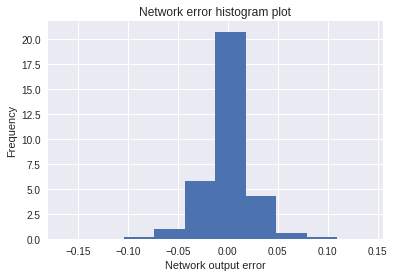

Error; maximal over inputs, average over dropout:
True values array mean: 0.500692 variance 0.042885
Experiment 0.033990 Std 0.027948
Equation   0.196389 Std 0.180351
Tightness  17.3% Std 15.5%


(0.03399035, 0.027948234, 0.1963887852644049, 0.18035096167473552, 0.042885114)

In [3]:
RandomExperiment(N = [10, 10, 5], P = 0.1, KLips = 0.1, do_print = True).run(inputs = 6, repetitions = 10000, do_print = True, do_plot = True, do_tqdm = True)

In [4]:
Ls = range(2, 11)
results = [RandomExperiment(P = 0.01, N = [10] * L + [1], KLips = 0.01).run(inputs = 5, do_tqdm = False, do_plot = False, do_print = False) for L in tqdm(Ls)]

100%|██████████| 9/9 [00:27<00:00,  3.59s/it]


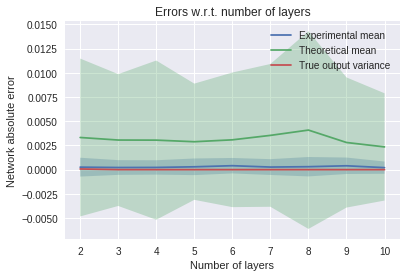

In [5]:
mean_exp, std_exp, mean_bound, std_bound, std_true = [np.array(x) for x in zip(*results)]
plt.figure()
plt.title('Errors w.r.t. number of layers')
plt.xlabel('Number of layers')
plt.ylabel('Network absolute error')
plt.plot(Ls, mean_exp, label = 'Experimental mean')
plt.fill_between(Ls, mean_exp - std_exp, mean_exp + std_exp, alpha = 0.3)
plt.plot(Ls, mean_bound, label = 'Theoretical mean')
plt.fill_between(Ls, mean_bound - std_bound, mean_bound + std_bound, alpha = 0.3)
plt.plot(Ls, std_true, label = 'True output variance')
plt.legend()
plt.show()

Mean error 0.03659, 10.49% from theoretical, norm 0.81
Mean error 0.03823, 10.96% from theoretical, norm 0.92
Mean error 0.04017, 11.52% from theoretical, norm 1.04
Mean error 0.04160, 11.93% from theoretical, norm 1.21
Mean error 0.04362, 12.51% from theoretical, norm 1.37
Mean error 0.04431, 12.71% from theoretical, norm 1.50
Mean error 0.04567, 13.10% from theoretical, norm 1.61
Mean error 0.04603, 13.20% from theoretical, norm 1.73
Mean error 0.04609, 13.22% from theoretical, norm 1.73
Mean error 0.04668, 13.39% from theoretical, norm 1.85


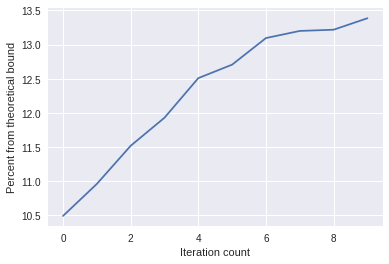

In [6]:
np.random.seed(42)

# Setting parameters and creating the experiment
N = 5
L = 2
p = 0.1
K_ = 0.1
repetitions = 10000
to_add = 10
to_keep = 5
experiment = RandomExperiment([N] * L + [1], [p] * (L - 1), K_)

mean_bound, std_bound = experiment.get_mean_std_error()

# creating initial inputs
data = np.random.randn(to_keep, N)

# percents from theoretical bound
percents = []

maxiter = 10

for _ in range(maxiter):
  data_ = data

  # Randomizing inputs
  for input_ in data_:
    rand_direction = np.random.randn(to_add, N)
    rand_direction /= np.linalg.norm(rand_direction, axis = 0)
    rand_direction *= 0.5
    input_ = input_ + rand_direction
    data = np.vstack((data, input_))

  # Computing true values
  trues = [experiment.predict_no_dropout(value) for value in data]

  # Running the experiment
  errors = [experiment.get_error(value, repetitions = repetitions) for value in data]

  # List of errors for inputs
  error_array = np.mean(np.max(np.abs(errors), axis = 2), axis = 1)

  max_exp = np.max(error_array)
  
  # Choosing maximal error
  indices = np.argsort(-error_array)

  # Choosing best to_keep entries
  data = data[indices[:to_keep]]
  
  percent = 100 * max_exp / mean_bound
  print('Mean error %.5f, %.2f%% from theoretical, norm %.2f' % (max_exp, percent, np.linalg.norm(data.flatten()) / data.shape[0]))
  percents.append(percent)
  
plt.xlabel('Iteration count')
plt.ylabel('Percent from theoretical bound')
plt.plot(percents)
plt.show()

In [0]:
# Trying genetic search for x

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 11s 1us/step


100%|██████████| 10000/10000 [00:00<00:00, 52114.87it/s]


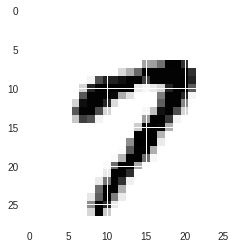

In [9]:
plt.imshow(x_train[15])
x_train = np.array([elem.flatten() for elem in x_train])
x_test = np.array([elem.flatten() for elem in x_test])
y_train = np.array([[1 if i == digit else 0 for i in range(10)] for digit in tqdm(y_train.flatten())])
y_test = np.array([[1 if i == digit else 0 for i in range(10)] for digit in tqdm(y_test.flatten())])

In [0]:
def create_trainable_model(Ns, KLips):
  """ Create some simple network with given dropout prob, weights and Lipschitz coefficient for sigmoid """
  
  # creating model
  model = Sequential()

  # adding layers
  for i in range(len(Ns) - 1):
    # adding dense layer with sigmoid for hidden and linear for last layer
    model.add(Dense(Ns[i + 1], input_shape = (Ns[i], ),
                    kernel_initializer = 'random_normal',
                    activation = get_custom_activation(KLips),
                    bias_initializer = 'zeros'))

  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

  model.summary()
  return model

In [11]:
model = create_trainable_model([28 ** 2,100,10], 1)
history = model.fit(x_train, y_train, batch_size=100, epochs=10, verbose=1, validation_data = (x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 100)               78500     
_________________________________________________________________
dense_118 (Dense)            (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.6363 - acc: 0.8016 - val_loss: 0.4056 - val_acc: 0.8756
Epoch 2/10
60000/60000 [==============================] - 4s 58us/step - loss: 0.3780 - acc: 0.8835 - val_loss: 0.3462 - val_acc: 0.8952
Epoch 3/10
60000/60000 [==============================] - 4s 58us/step - loss: 0.3318 - acc: 0.8989 - val_loss: 0.2993 - val_acc: 0.9082
Epoch 4/10
60000/60000 [==============================] - 3s 58us/step - 

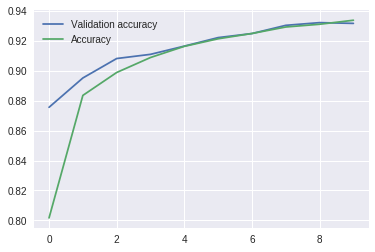

In [12]:
plt.figure()
plt.plot(history.history['val_acc'], label = 'Validation accuracy')
plt.plot(history.history['acc'], label = 'Accuracy')
plt.legend()
plt.show()

8


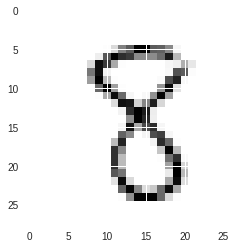

In [13]:
w1 = model.get_weights()[0]
b1 = model.get_weights()[1]
w2 = model.get_weights()[2]
b2 = model.get_weights()[3]

idx = 144
print(np.argmax((x_train[idx] @ w1 + b1) @ w2 + b2))
plt.imshow(x_train[idx].reshape(28, 28))

In [0]:
W = model.get_weights()[0::2]
B = model.get_weights()[1::2]

In [0]:
# Next steps:
# 1. Make Experiment() abstract, move random code to RandomExperiment()
# 2. Implement MNISTExperiment()
# 3. Check if on MNIST the gap between theory and experiment is still high, on images as data